### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display
import pyproj

#For plotting
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

from importlib import reload

In [2]:
def getXYproj(source_url):
    """
    Given netCDF-file, returns X, Y arrays and projection.
    """
    try:
        ncfile = Dataset(source_url)
        var = ncfile.variables['projection_stere']
        proj4 = var.__getattr__('proj4')
        X = ncfile.variables['X'][:]
        Y = ncfile.variables['Y'][:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()
    
    proj = pyproj.Proj(proj4)
    
    return X, Y, proj

    
def lonlat2xygpuocean(source_url, lon, lat, x0, y0, norkyst = True):
    """
    Takes in NetCDF-file, x, y coordinates(single or lists) and x0, y0 of GPU Ocean-domain. 
    Returns x, y projection of lon, lat.
    If X, Y and proj are given, netCDF-file is not opened.
    """
    if norkyst:
        X, Y, proj = getXYproj(source_url)
    else:
        proj_str= '+proj=stere +ellps=WGS84 +lat_0=90.0 +lat_ts=60.0 +x_0=3192800 +y_0=1784000 +lon_0=70'
        proj = pyproj.Proj(proj_str)
        try:
            ncfile = Dataset(source_url)
            lon_rho = ncfile.variables['lon_rho'][:]
            lat_rho = ncfile.variables['lat_rho'][:]
        except Exception as e:
            raise e
        finally:
            ncfile.close()
            
        X, Y = proj(lon_rho, lat_rho, inverse = False)
        X = X[0]
        Y = Y[:,0] 
    
    #Finding tentative x,y(not for a specific domain)
    x, y = proj(lon,lat, inverse = False)

    #Find new x,y in gpuocean coordinates for initial position
    x = x - X[int(x0) + 2]
    y = y- Y[int(y0) + 2]
    
    return x, y

def xygpuocean2lonlat(source_url, x, y, x0, y0, X= None, Y= None, proj = None):
    """
    Takes in NetCDF-file, longitude and latitude coordinates and x0, y0 of GPU Ocean-domain. 
    Returns lon, lat equivalent of x, y. 
    If X, Y and proj are given, netCDF-file is not opened.
    """
    if (X is None) or (Y is None) or (proj is None):
        X, Y, proj = getXYproj(source_url)
        
    x = x + X[x0+2]
    y = y + Y[y0+2]
    
    lon, lat = proj(x, y, inverse = True)

    return lon, lat


In [3]:
#z_source_url = "C:\\Users\\florianb\\Downloads\\NorKyst-800m_ZDEPTHS_his.an.2019071600.nc"
z_source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

In [4]:
z_nc = Dataset(z_source_url)

In [5]:
lat1, lon1 = 58.46175,  8.77245
lat2, lon2 = 57.72500, 10.57919

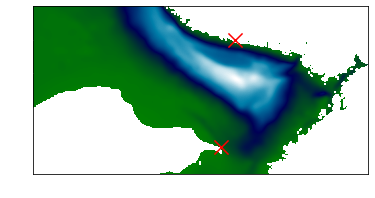

In [6]:
mask = z_nc["zeta"][0,0:250,0:500].mask.copy()
plt.imshow(np.ma.array(z_nc["h"][0:250,0:500], mask=mask.copy()), origin="lower", cmap="ocean")
plt.scatter(300,200, marker="x", c="red", s=200.0)
plt.scatter(280,40, marker="x", c="red", s=200.0)

In [7]:
x1, y1 = 300, 200
x2, y2 = 280, 40

In [8]:
x, y = x1, y1
x_step, y_step = x2-x1, y2-y1

all_xs, all_ys = [x1], [y1]

while all_xs[-1] != x2 or all_ys[-1] != y2:
    x = x + x_step/200
    y = y + y_step/200
    if all_xs[-1] != round(x) or all_ys[-1] != round(y):
        all_xs.append(round(x))
        all_ys.append(round(y))

In [9]:
xs, ys = [], []
for i in range(len(all_xs)):
    try:
        z_nc["zeta"][0,all_ys[i],all_xs[i]].mask 
    except:
        xs.append(all_xs[i])
        ys.append(all_ys[i])

In [10]:
lats = []
for i in range(len(xs)):
    lats.append(float(z_nc["lat"][ys[i],xs[i]].data))

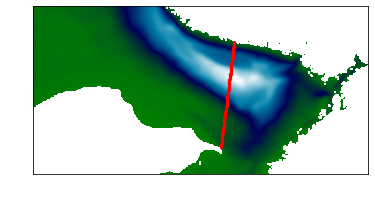

In [11]:
plt.imshow(np.ma.array(z_nc["h"][0:250,0:500], mask=mask.copy()), origin="lower", cmap="ocean")
plt.scatter(xs, ys, c="red", s=5.0)

In [12]:
z_depths = z_nc["depth"][:].data

In [13]:
z_temps = []
for i in range(len(xs)):
    z_temps.append(z_nc["temperature"][0,:,ys[i],xs[i]])
z_temps = np.ma.array(z_temps)

In [14]:
z_sals = []
for i in range(len(xs)):
    z_sals.append(z_nc["salinity"][0,:,ys[i],xs[i]])
z_sals = np.ma.array(z_sals)

In [15]:
import seawater as sw

In [16]:
z_pressures = np.zeros((len(lats), len(z_depths)))
for l in range(len(lats)):
    for d in range(len(z_depths)):
        z_pressures[l,d] = sw.eos80.pres(z_depths[d],lats[l])

In [17]:
z_densities = np.ma.array(np.zeros_like(z_temps),mask=z_temps.mask.copy())
for l in range(len(lats)):
    for d in range(len(z_depths)):
        if not z_densities.mask[l,d]:
            z_densities[l,d] = sw.eos80.dens(z_sals[l,d],z_temps[l,d],z_pressures[l,d])

In [18]:
z_densities_show = z_densities[:,0]
d_up = 0 
for i in range(len(z_nc["depth"][:13].data)):
    d = z_nc["depth"][:-1].data[i]
    z_densities_show = np.ma.vstack([z_densities_show, np.tile(z_densities[:,i],(int(d - d_up),1))])
    d_up = d

Text(0, 0.5, 'Depth')

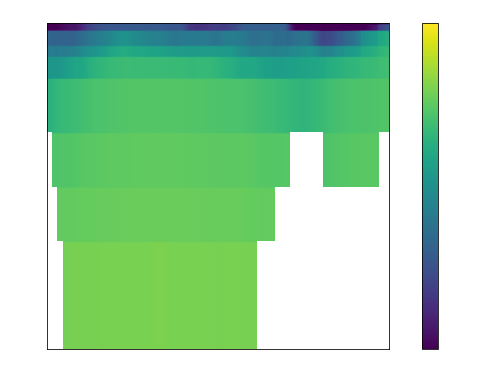

In [19]:
fig = plt.figure(figsize=(12,6))
plt.imshow(z_densities_show[0:150,:], vmin=1020, vmax=1030)
plt.colorbar()
plt.title("Densities")
plt.ylabel("Depth")

Now with s-level file

Re-using the coordinate vector

In [20]:
#s_source_url = "C:\\Users\\florianb\\Downloads\\ocean_his.an.20190716.nc"
s_source_url = "https://thredds.met.no/thredds/dodsC/fou-hi/new_norkyst800m/his/ocean_his.an.20190716.nc"

In [21]:
s_nc = Dataset(s_source_url)

In [22]:
s_rhos = s_nc["Cs_r"][:].data

s_hs = []
for i in range(len(lats)):
    s_hs.append(s_nc["h"][ys[i],xs[i]].data.item())

In [23]:
s_depths = np.zeros((len(s_hs),len(s_rhos)))
for l in range(len(s_hs)):
    for s in range(len(s_rhos)):
        s_depths[l,s] = s_hs[l]*s_rhos[s]

Text(0.5, 0, 'Arendal <<< >>> Skagen')

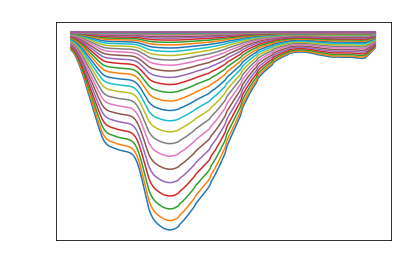

In [24]:
for s in range(len(s_rhos)):
    plt.plot(s_depths[:,s])
plt.title("s levels")
plt.ylabel("depth")
plt.xlabel("Arendal <<< >>> Skagen")

In [25]:
s_temps = []
for i in range(len(xs)):
    s_temps.append(s_nc["temp"][0,:,ys[i],xs[i]].data)
s_temps = np.array(s_temps)

In [26]:
s_sals = []
for i in range(len(xs)):
    s_sals.append(s_nc["salt"][0,:,ys[i],xs[i]].data)
s_sals = np.array(s_sals)

In [27]:
s_pressures = np.zeros((len(lats), len(s_rhos)))
for l in range(len(lats)):
    for d in range(len(s_rhos)):
        s_pressures[l,d] = sw.eos80.pres(-s_hs[l]*s_rhos[d],lats[l])

In [28]:
s_densities = np.zeros_like(s_temps)
for l in range(len(lats)):
    for d in range(len(s_rhos)):
        s_densities[l,d] = sw.eos80.dens(s_sals[l][d],s_temps[l][d],s_pressures[l][d])

In [29]:
s_densities_show = np.ma.array(np.zeros((len(lats),1000)))
for l in range(len(lats)):
    d_up = 0 
    for i in reversed(range(len(s_rhos))):
        d = round(-(s_hs[l]*s_rhos[i]))
        s_densities_show[l,d_up:d] = s_densities[l][i]
        d_up = d
s_densities_show.mask = (s_densities_show==0)

Text(0, 0.5, 'Depth')

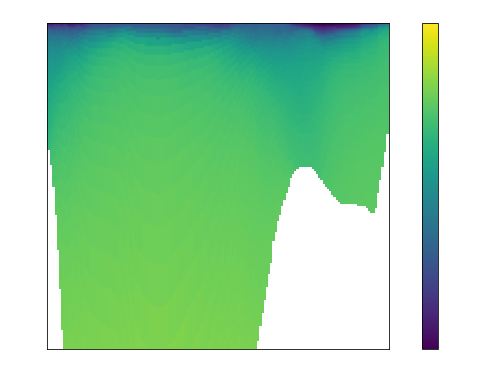

In [30]:
fig = plt.figure(figsize=(12,6))
plt.imshow(s_densities_show.T[0:150], vmin=1020, vmax=1030)
plt.colorbar()
plt.title("Densities")
plt.ylabel("Depth")

Analysis of differences in results

Text(0.5, 0, 'Arendal <<< >>> Skagen')

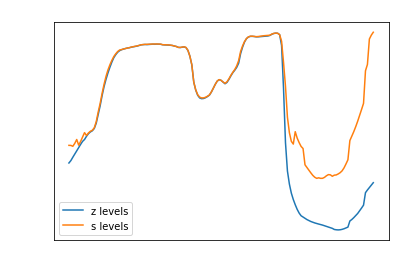

In [31]:
plt.plot(z_densities_show[0,:], label="z levels")
plt.plot(s_densities_show[:,0], label="s levels")
plt.title("Surface density")
plt.legend(labelcolor="black")
plt.ylabel("dens")
plt.xlabel("Arendal <<< >>> Skagen")

Example location (index 50)

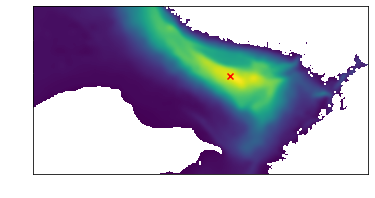

In [32]:
plt.imshow(np.ma.array(z_nc["h"][0:250,0:500], mask=mask.copy()), origin="lower")
plt.scatter(xs[50], ys[50], marker="x", c="red")

In [33]:
z_nc["lat"][ys[50],xs[50]], s_nc["lat_rho"][ys[50],xs[50]]

(masked_array(data=58.22356832,
              mask=False,
        fill_value=1e+20),
 masked_array(data=58.22356832,
              mask=False,
        fill_value=1e+20))

In [34]:
z_nc["lon"][ys[50],xs[50]], s_nc["lon_rho"][ys[50],xs[50]]

(masked_array(data=9.40334075,
              mask=False,
        fill_value=1e+20),
 masked_array(data=9.40334075,
              mask=False,
        fill_value=1e+20))

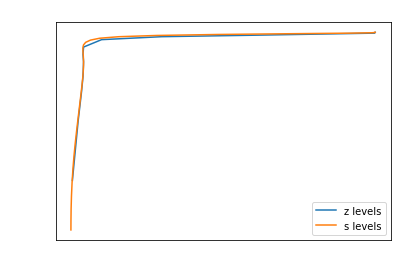

In [35]:
plt.plot(z_nc["temperature"][0,0:13,ys[50],xs[50]], -z_nc["depth"][0:13], label="z levels")
plt.plot(s_nc["temp"][0,:,ys[50],xs[50]], s_nc["Cs_r"][:]*s_nc["h"][ys[50],xs[50]], label= "s levels")
plt.title("Vertical temperature profile")
plt.ylabel("depth")
plt.xlabel("temp in degC")
plt.legend(labelcolor="black")

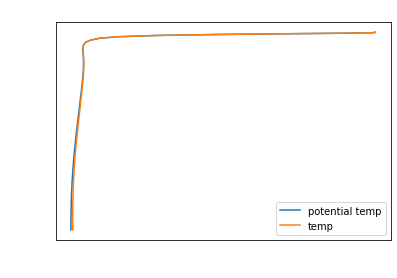

In [39]:
plt.plot(s_temps[50], s_depths[50], label= "potential temp")
plt.plot(sw.temp(s_sals[50], s_temps[50], s_pressures[50]), s_depths[50], label="temp")
plt.title("Potential temperature vs temperature")
plt.ylabel("depth")
plt.xlabel("temp in degC")
plt.legend(labelcolor="black")